In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:

csv_path = "/content/OD-IDS2022-Dataset.csv"
df = pd.read_csv(csv_path, low_memory=False)

print("Shape:", df.shape)
print("Columns:\n", df.columns.tolist()[:50])
df.head()


Shape: (1031916, 82)
Columns:
 ['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt']


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,198.51.100.116,58598,172.217.163.129,443,6,114748,12,9,788,5944,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal
1,198.51.100.116,34538,54.246.133.196,443,6,1782409,9,8,910,4962,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal
2,198.51.100.116,34538,54.246.133.196,443,6,7619,3,2,85,1448,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal
3,198.51.100.116,34540,54.246.133.196,443,6,2302827,258,302,846,563388,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal
4,198.51.100.116,34540,54.246.133.196,443,6,5864,5,2,85,1448,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal


In [ ]:
# --- 3. IP → OCTETS ---

def ip_to_octets(ip_str):
    """Convert 'A.B.C.D' -> [A, B, C, D]. If bad/missing -> [0,0,0,0]."""
    try:
        parts = str(ip_str).split('.')
        if len(parts) != 4:
            return [0, 0, 0, 0]
        return [int(p) if p.isdigit() else 0 for p in parts]
    except Exception:
        return [0, 0, 0, 0]


for col in ["SrcIP", "DstIP"]:
    if col in df.columns:
        octet_values = df[col].fillna("0.0.0.0").apply(ip_to_octets)
        octet_array = np.vstack(octet_values.values)

        df[f"{col}_o1"] = octet_array[:, 0]
        df[f"{col}_o2"] = octet_array[:, 1]
        df[f"{col}_o3"] = octet_array[:, 2]
        df[f"{col}_o4"] = octet_array[:, 3]

        # Droping raw IP string column
        df.drop(columns=[col], inplace=True)

df.head()


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,198.51.100.116,58598,172.217.163.129,443,6,114748,12,9,788,5944,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal
1,198.51.100.116,34538,54.246.133.196,443,6,1782409,9,8,910,4962,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal
2,198.51.100.116,34538,54.246.133.196,443,6,7619,3,2,85,1448,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal
3,198.51.100.116,34540,54.246.133.196,443,6,2302827,258,302,846,563388,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal
4,198.51.100.116,34540,54.246.133.196,443,6,5864,5,2,85,1448,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Apache_flink_directory_traversal


In [ ]:

if "Label" in df.columns:
    label_col = "Label"
else:

    label_col = df.columns[-1]
print("Using label column:", label_col)

y_raw = df[label_col]
X_all = df.drop(columns=[label_col])

X_numeric = X_all.select_dtypes(include=[np.number]).copy()
print("Numeric feature count:", X_numeric.shape[1])

X_numeric = X_numeric.fillna(X_numeric.median())

le = LabelEncoder()
y = le.fit_transform(y_raw)

print("Classes:", le.classes_)
num_classes = len(le.classes_)
print("Number of classes:", num_classes)


Using label column: Label
Numeric feature count: 79
Classes: ['ARP_Spoofing' 'Apache_flink_directory_traversal'
 'Authenticated Remote Code Execution' 'BENIGN' 'Brute Force Attacks'
 'DLL Hijacking' 'Denial-of-service' 'Distributed_denial-of-service'
 'EXE HijackinPrintNightMare-RCE' 'EXE Hijacking'
 'Exploiting Node Deserialization' 'Firmware Vulnerabilitie'
 'Fragmented Packet Attacks'
 'Google Chrome Remote Code Execution via Browser' 'Kernel Exploitation'
 'Man-in-the-middle' 'ManageEngine ADSelfService Plus 6.1 - CSV Injection'
 'Persistent Cross-Site Scripting in Blog page'
 'Print Spooler Service - Local Privilege Escalation'
 'Privilege Escalation Using Unquoted Service Path' 'Ransomware (Malware)'
 'Remote Code Execution via Unrestricted File Upload access' 'SYN Floods'
 'Slow_HTTP_attack' 'TCP_Session_Hijacking' 'Time-based SQL Injection'
 'Unauthenticated Arbitrary File Upload'
 'Unauthenticated RCE in Credit Card Customer Care System'
 'Webmin 1.962 - Package Update Escape 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X_numeric.values,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (825532, 79) Test shape: (206384, 79)


In [ ]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)

np.savez(
    "scaler_params_odids2022.npz",
    mean_=scaler.mean_,
    scale_=scaler.scale_,
    feature_names=np.array(X_numeric.columns)
)

np.save("label_classes_odids2022.npy", le.classes_)


Scaled shapes: (825532, 79) (206384, 79)


In [ ]:

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {int(c): w for c, w in zip(np.unique(y_train), class_weights_array)}
class_weights


{0: np.float64(0.5786957103871678),
 1: np.float64(0.6224389008102325),
 2: np.float64(6.623224916159882),
 3: np.float64(0.5232546126069366),
 4: np.float64(0.5589362004644645),
 5: np.float64(7.909591744833335),
 6: np.float64(1.7092963065723052),
 7: np.float64(0.3555127971032967),
 8: np.float64(9.792439177727957),
 9: np.float64(8.859825922706248),
 10: np.float64(11.251628731089001),
 11: np.float64(0.3308417964233601),
 12: np.float64(0.2826256497056767),
 13: np.float64(4.6959123539516945),
 14: np.float64(11.220583638019383),
 15: np.float64(0.40503430024266773),
 16: np.float64(4.201095143101413),
 17: np.float64(16.824243906415585),
 18: np.float64(6.514100844314685),
 19: np.float64(4.735754564906866),
 20: np.float64(7.314136867845625),
 21: np.float64(2.578965454761295),
 22: np.float64(0.2025301176739011),
 23: np.float64(0.7755727084147551),
 24: np.float64(2.34428235935561),
 25: np.float64(2.138739345578901),
 26: np.float64(8.895818965517241),
 27: np.float64(7.99848

In [ ]:

input_dim = X_train_scaled.shape[1]

def build_dnn(input_dim, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_dnn(input_dim, num_classes)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,469 (490.11 KB)

 Trainable params: 124,189 (485.11 KB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = "odids_dnn_tf19.h5"

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=1024,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("Best model saved to:", checkpoint_path)


Epoch 1/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6595 - loss: 1.8433
Epoch 1: val_loss improved from inf to 1.06316, saving model to odids_dnn_tf19.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.6595 - loss: 1.8433 - val_accuracy: 0.6799 - val_loss: 1.0632 - learning_rate: 1.2500e-04
Epoch 2/100
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6586 - loss: 1.8443
Epoch 2: val_loss did not improve from 1.06316
645/645 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.6586 - loss: 1.8443 - val_accuracy: 0.6792 - val_loss: 1.0654 - learning_rate: 1.2500e-04
Epoch 3/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6575 - loss: 1.8520
Epoch 3: val_loss improved from 1.06316 to 1.05756, saving model to odids_dnn_tf19.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.6575 - loss: 1.8520 - val_accuracy: 0.6801 - val_loss: 1.0576 - learning_rate: 1.2500e-04
Epoch 4/100
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6592 - loss: 1.8323
Epoch 4: val_loss improved from 1.05756 to 1.04907, saving model to odids_dnn_tf19.h5


645/645 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.6592 - loss: 1.8324 - val_accuracy: 0.6826 - val_loss: 1.0491 - learning_rate: 1.2500e-04
Epoch 5/100
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6590 - loss: 1.8402
Epoch 5: val_loss did not improve from 1.04907
645/645 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.6590 - loss: 1.8402 - val_accuracy: 0.6811 - val_loss: 1.0685 - learning_rate: 1.2500e-04
Epoch 6/100
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6583 - loss: 1.8472
Epoch 6: val_loss did not improve from 1.04907
645/645 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.6583 - loss: 1.8472 - val_accuracy: 0.6824 - val_loss: 1.0603 - learning_rate: 1.2500e-04
Epoch 7/100
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6591 - loss: 1.8530
Epoch 7: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 7: val_loss did not improve from 1.04907
645/645 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.6591 - loss: 1.8530 -

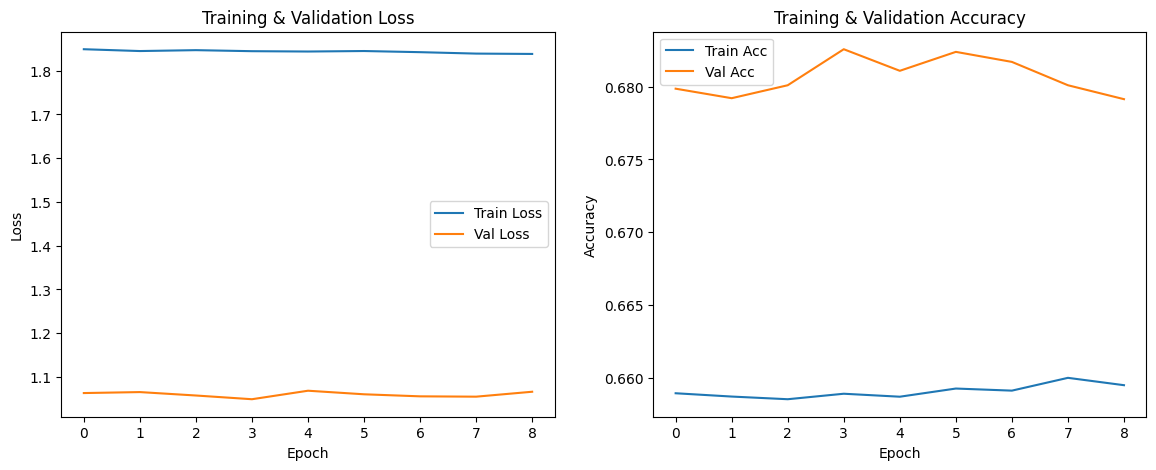

In [ ]:


plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


In [ ]:

y_proba = model.predict(X_test_scaled, batch_size=2048)
y_pred = np.argmax(y_proba, axis=1)

# Accuracy & Error
acc = accuracy_score(y_test, y_pred)
error = 1.0 - acc
print(f"Accuracy: {acc:.4f}")
print(f"Error:    {error:.4f}")

# Precision, Recall, F1
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

print("\nMacro Precision :", round(prec_macro, 4))
print("Macro Recall    :", round(rec_macro, 4))
print("Macro F1-score  :", round(f1_macro, 4))

print("\nWeighted Precision :", round(prec_weighted, 4))
print("Weighted Recall    :", round(rec_weighted, 4))
print("Weighted F1-score  :", round(f1_weighted, 4))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Accuracy: 0.6827
Error:    0.3173

Macro Precision : 0.4246
Macro Recall    : 0.4519
Macro F1-score  : 0.4064

Weighted Precision : 0.77
Weighted Recall    : 0.6827
Weighted F1-score  : 0.7111

Classification Report:

                                                           precision    recall  f1-score   support

                                             ARP_Spoofing       0.99      0.58      0.73     12298
                         Apache_flink_directory_traversal       0.95      0.83      0.88     11433
                      Authenticated Remote Code Execution       0.09      0.20      0.13      1075
                                                   BENIGN       0.72      0.57      0.64     13601
                                      Brute Force Attacks       0.54      0.51      0.53     12733
                                            DLL Hijacking       0.24      0.18      0.21       900
                                        Denial

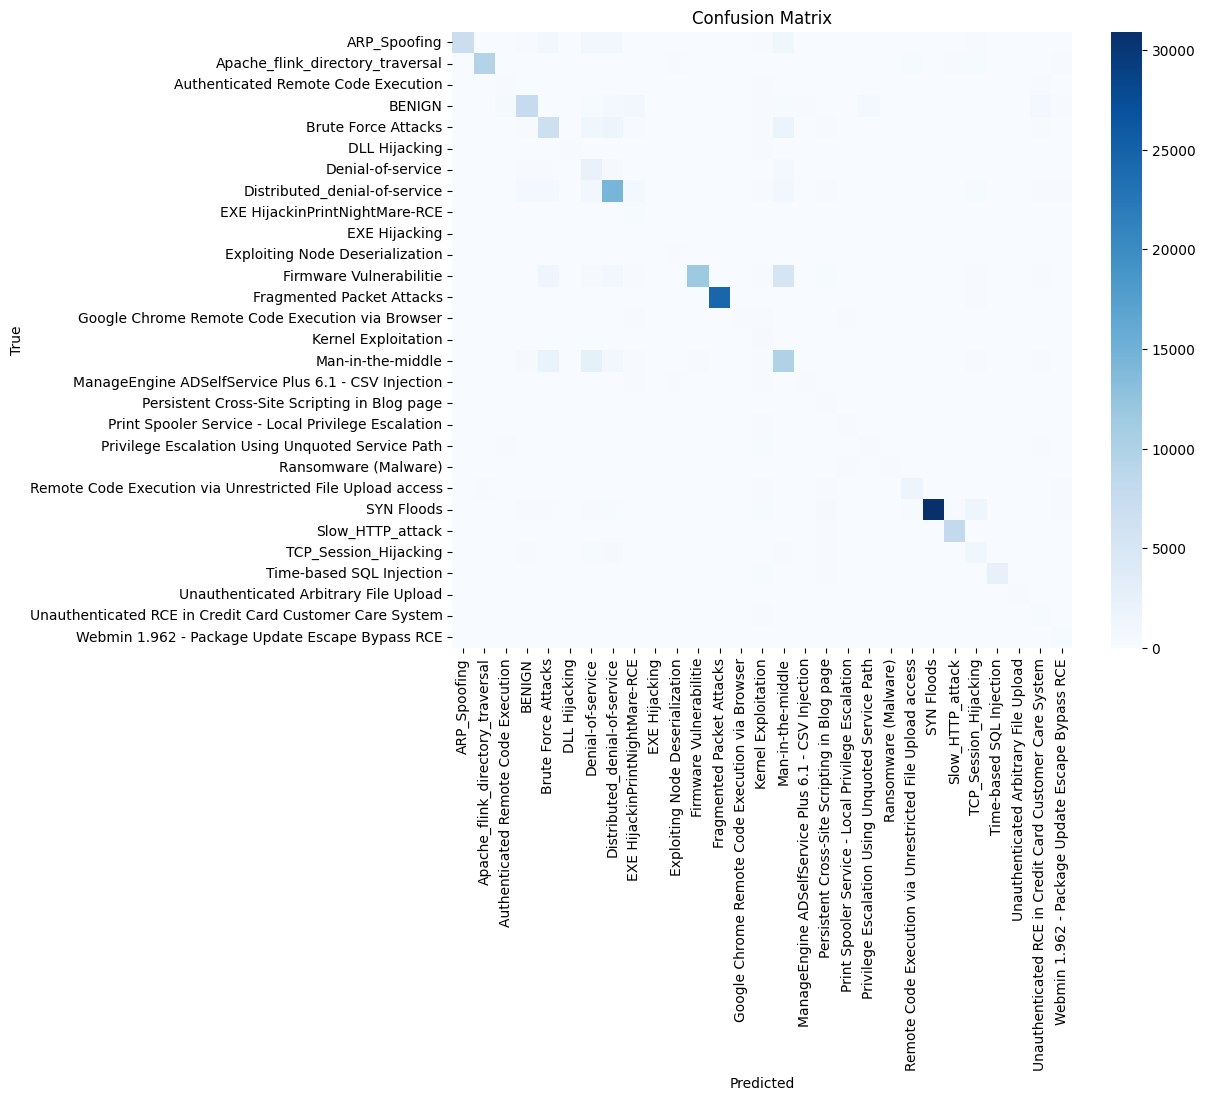

In [ ]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=False,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# --- 13. ROC-AUC (multi-class) ---

# Converting true labels to one-hot for ROC AUC
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=num_classes)

try:
    roc_auc_ovr = roc_auc_score(
        y_test_onehot,
        y_proba,
        multi_class="ovr",
        average="macro"
    )
    print("Macro ROC-AUC (OVR):", round(roc_auc_ovr, 4))
except Exception as e:
    print("ROC-AUC could not be computed:", e)


Macro ROC-AUC (OVR): 0.9592


In [ ]:

# Per-feature variance (on scaled data; should be ~1 because of StandardScaler)
feature_variances = X_train_scaled.var(axis=0)
var_df = pd.DataFrame({
    "feature": X_numeric.columns,
    "variance": feature_variances
}).sort_values("variance", ascending=False)

print("Top 20 features by variance (scaled):")
var_df.head(20)


Top 20 features by variance (scaled):


,feature,variance
45,FIN Flag Cnt,1.0
72,Active Std,1.0
24,Fwd IAT Std,1.0
49,ACK Flag Cnt,1.0
51,CWE Flag Count,1.0
75,Idle Mean,1.0
71,Active Mean,1.0
46,SYN Flag Cnt,1.0
19,Flow IAT Std,1.0
64,Subflow Fwd Byts,1.0


Covariance matrix shape: (79, 79)


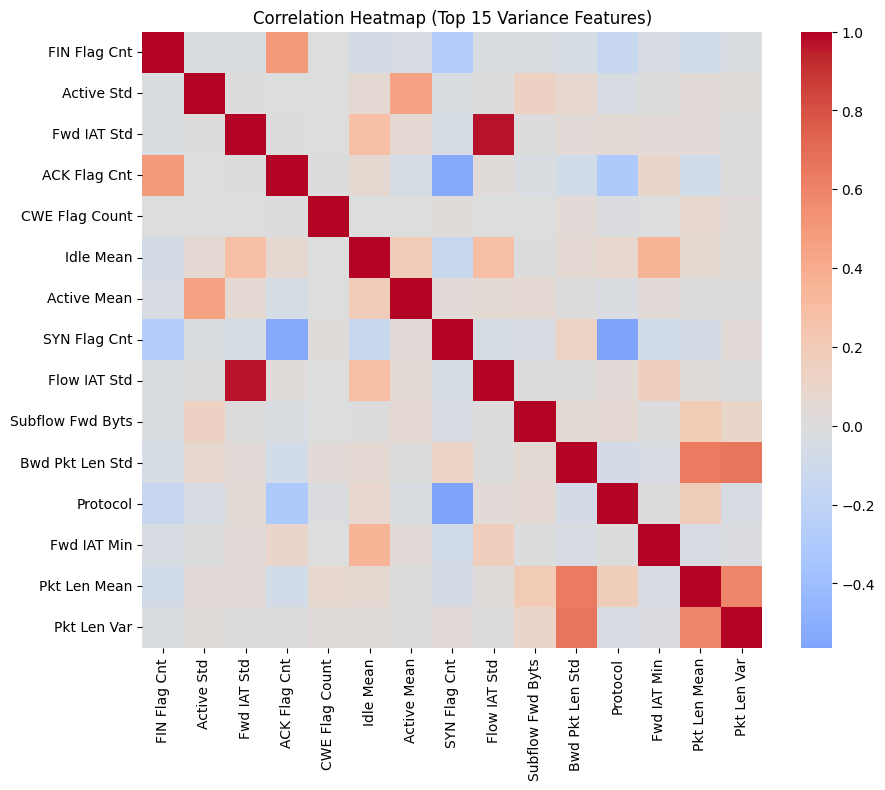

In [ ]:
# Covariance on original numeric features (could be heavy; sample a subset)
sampled = X_numeric.sample(n=min(5000, len(X_numeric)), random_state=42)
cov_matrix = np.cov(sampled.values.T)

print("Covariance matrix shape:", cov_matrix.shape)

# Optionally visualize correlation of top 15 highest-variance features
top_features = var_df.head(15)["feature"].tolist()
corr = sampled[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Top 15 Variance Features)")
plt.show()


In [ ]:
# True one-hot vs predicted probabilities
y_true_onehot = keras.utils.to_categorical(y_test, num_classes=num_classes)

# Bias: mean squared difference between average prediction and average truth
mean_pred = np.mean(y_proba, axis=0)
mean_true = np.mean(y_true_onehot, axis=0)
bias_vector = mean_pred - mean_true
bias_squared = np.mean(bias_vector ** 2)

# Variance: average variance of predicted probas per class
variance_vector = np.var(y_proba, axis=0)
variance_scalar = np.mean(variance_vector)

print("Approx. Bias^2:", round(bias_squared, 6))
print("Approx. Variance:", round(variance_scalar, 6))


Approx. Bias^2: 0.000191
Approx. Variance: 0.017373


In [ ]:

model.save("odids_dnn_tf19_final.h5")
print("Final model saved as: odids_dnn_tf19_final.h5")


Final model saved as: odids_dnn_tf19_final.h5
